In [1]:
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import scipy as sp
import networkx as nx
import collections
import time
import math
import cProfile
from collections import Counter

In [2]:
def neighbor_nodes(graph, num_nodes):
    
    neighbor_dict = {key : [] for key in range(num_nodes)}
    # if input graph is complete
    if np.sum(graph.todense()) == num_nodes*(num_nodes-1):
        for key in neighbor_dict:
            neighbor_dict[key] = list(range(num_nodes))
            neighbor_dict[key].remove(key)
    else:
        # Checking each row and col that has an edge (element = 1)
        for row, col in zip(*graph.nonzero()):
            neighbor_dict[row].append(col)
        
    return neighbor_dict

def output_update(path, output_matrix):
    pair = [(path[i], path[i + 1]) for i in range(len(path)-1)]
    for i in pair:
        output_matrix[i[0], i[1]] = 1
        output_matrix[i[1], i[0]] = 1
    return output_matrix

## Fastest

def sample_spanning_tree(A):
    # Step 0: function setup
    num_nodes = A.shape[0]
    mat_A = A.todense()
    unvisited_node = set(range(num_nodes))
    walk_hist = np.empty(0, dtype= np.int32)
    is_connected = False
    output_init = sp.sparse.lil_matrix((num_nodes, num_nodes), dtype = np.int32)
    neighbor_dict = neighbor_nodes(A, num_nodes)
    #print(neighbor_dict)
    
    # Step 1: random the start and terminal node
    start_node = random.choice(tuple(unvisited_node))
    unvisited_node.remove(start_node)
    terminal_node = random.choice(tuple(unvisited_node))
    walk_hist = np.append(walk_hist, start_node)
    #print((start_node, terminal_node))
    #unvisited_node.remove(terminal_node)
    current_node = start_node
    
    # Step 2: perform Loop-erased Random walk and get the main path (T1 = LE(W1))
    while terminal_node in unvisited_node: # until first path is complete
        feasible_nodes = neighbor_dict[current_node] # randomly pick the neighbor node
        next_node = random.choice(feasible_nodes)
        current_node = next_node
        walk_hist = np.append(walk_hist, current_node) # This is W1
        if current_node in unvisited_node:
            unvisited_node.remove(current_node)
        else: # this creates a loop
            # update the walk_hist, insert the looped node back to unvisited_node and reset to where it starts
            index = np.where(walk_hist == current_node)[0][0]
            unvisited_node = unvisited_node.union(set(walk_hist[index+1:-1]))
            walk_hist = walk_hist[:index+1]
    visited_node = set(walk_hist)
    #print("walk_hist = ", walk_hist)
    output = output_update(walk_hist, output_init)
    # if a spanning tree is created in this step, skip step 3
    if len(unvisited_node) == 0:
        is_connected = True
    #print("unvisited_node = ", unvisited_node)
    
    # Step 3: initiate a new unvisited node and perform LERW until it joins some node of T1
    new_walk_hist = np.empty(0, dtype= np.int32)
    while len(unvisited_node) != 0 or is_connected == False:      
        if len(new_walk_hist) == 0:
            new_start_node = random.choice(tuple(unvisited_node))
            new_walk_hist = np.append(new_walk_hist, new_start_node)
            unvisited_node.remove(new_start_node)
            new_current_node = new_start_node
        #print(new_current_node)
        feasible_nodes = neighbor_dict[new_current_node]
        new_next_node = random.choice(feasible_nodes)
        #print("-",new_next_node)
        new_current_node = new_next_node
        new_walk_hist = np.append(new_walk_hist, new_current_node)
        if new_current_node in unvisited_node:
            if len(unvisited_node) == 1: #last node
                continue
            else: # normal walk
                unvisited_node.remove(new_current_node)
        elif new_current_node in visited_node: # it hits some node in T_i
            is_connected = True # in the second-round walk, it definitely confirms hitting some node in T1
            visited_node = visited_node.union(set(new_walk_hist))
            # update the output into sparse matrix
            output = output_update(new_walk_hist, output)
            new_walk_hist = np.empty(0, dtype=np.int32) # clear all history and restart the process 
            if len(visited_node) == num_nodes:
                break
        else: # this creates a loop
            # update the walk_hist, insert the looped node back to unvisited_node and reset to where it starts
            index = np.where(new_walk_hist == new_current_node)[0][0]
            unvisited_node = unvisited_node.union(set(new_walk_hist[index+1:-1]))
            new_walk_hist = new_walk_hist[:index+1]           
            
    return output # sparse matrix of a spanning tree

In [3]:
g5 = nx.to_scipy_sparse_matrix(nx.complete_graph(5))
g10 = nx.to_scipy_sparse_matrix(nx.complete_graph(10))

In [4]:
nx.from_numpy_matrix(sample_spanning_tree(g5))

## Prüfer sequence
(ref: https://en.wikipedia.org/wiki/Pr%C3%BCfer_sequence)

### Objective:
Can we modify the idea of Prufer sequence to generate tree faster for based on other network topologies?

### Goal:
Need two functions. One converts a Prufer sequence into a tree, and another one does conversely.

###  Algorithm to convert a tree to a Prufer
1. Remove vertices from the tree until only two vertices remain.
2. Each removal, set the i-th element of a sequence to be the label of its neighbor.

### Algorithm to convert a Prufer to a tree
1. Let P = [ ] a Prufer sequence with n elements
2. Then the tree will have n+2 elements (nodes), numbered from 1 to n+2
3. Each node, set its degree to the number of times it appears in the sequence plus 1
4. For each number in the sequence P[i], find the first (lowest-numbered) node, j, with degree equal to 1
5. Add the edge (j, P[i]) to the tree, and decrement the degrees of j and P[i]
6. At the end of the loop, two nodes with degree 1 will remain (use u and v). Then, add the edge (u,v) to the tree

In [5]:
"""# script test

seq = [2,2,3]
deg_count = Counter(seq)
tree = nx.empty_graph()
tree_dict = {}

for i in range(len(seq)+2):
    tree_dict[i] = deg_count[i]
u = next(j for j in range(len(seq)+2) if deg_count[j] == 1)
index = u

# add the edge to the tree and decrement the degrees of j and P[i]
for k in seq:
    tree.add_edge(u, seq[k])
    tree_dict[k] -= 1"""

'# script test\n\nseq = [2,2,3]\ndeg_count = Counter(seq)\ntree = nx.empty_graph()\ntree_dict = {}\n\nfor i in range(len(seq)+2):\n    tree_dict[i] = deg_count[i]\nu = next(j for j in range(len(seq)+2) if deg_count[j] == 1)\nindex = u\n\n# add the edge to the tree and decrement the degrees of j and P[i]\nfor k in seq:\n    tree.add_edge(u, seq[k])\n    tree_dict[k] -= 1'

In [6]:
# Tree to Prufer sequence

def tree_to_prufer(tree_mat):
    # Error checking
    ## I. The input must be a adjacency matrix
    if not(sp.sparse.isspmatrix(tree_mat)):
        raise TypeError("The tree must be an adjacency (sparse) matrix")

    # convert adjacency matrix to graph form
    tree = nx.from_numpy_matrix(tree_mat)
    # setup
    n = len(tree)
    deg_dict = dict(tree.degree())
    
    # Find parent nodes
    def parent_node(u):
        return next(i for i in tree[u] if deg_dict[i] > 1)

    prufer_seq = []
    u = next(j for j in range(n) if deg_dict[j] == 1) # Leaf node label
    index = u
    print("start at node ", u)
    for node in range(n-2): # for each node
        parent = parent_node(u)
        print("the parent node is ", parent)
        prufer_seq.append(parent+1)
        deg_dict[parent] -= 1 # delete that node after adding parent to sequence
        # Then setup the next node
        if parent < index and deg_dict[parent] == 1: # in case that parent node becomes next leaf node
            u = parent
            print("I. the next leaf node is ", u)
        else:
            u = next(j for j in range(index+1, n) if deg_dict[j] == 1) # in case that parent node is still parent node
            index = u
            print("II. the next leaf node is ", u)

    return prufer_seq

In [7]:
# Prufer sequence to Tree function

def prufer_to_tree(seq):
    # Error checking
    ## I. The sequence must be represented as a list.
    if not(isinstance(seq, list)):
        raise TypeError("The Prufer sequence must be a list.")
    ## II. The elements in the list must be a positive integer.
    for i in seq:
        if not(isinstance(i,int)):
            raise TypeError("The sequence must be integers.")
        if i < 0:
            raise ValueError("The sequence must be positive.")
       
    n = len(seq)
    deg = [0]*(n+2)
    zero_mat =np.zeros((n+2,n+2),dtype=np.int32)
    tree = sp.sparse.lil_matrix(zero_mat)

    for i in range(1, tree.shape[0]+1):
        deg[i-1] = 1

    for i in seq:
        deg[i-1] += 1

    # Next, for each number in sequence, find the first node j whose deg = 1
    for i in seq:
        for j in range(1, tree.shape[0]+1):
            if deg[j-1] == 1:
                tree[i-1,j-1] = 1
                tree[j-1,i-1] = 1
                deg[i-1] -= 1
                deg[j-1] -= 1
                break

    # At the end of the loop, two nodes with degree 1 will remain
    u = 0
    v = u
    for i in range(tree.shape[0]):
        if deg[i] == 1:
            if u == 0:
                u = i
            else:
                v = i
                break
    # Lastly, add the edge to the tree
    tree[u,v] = 1
    tree[v,u] = 1
    deg[u] -= 1
    deg[v] -= 1

    return tree

### Test case

In [8]:
# Tree to Prufer

samp_tree = sample_spanning_tree(g5)
print(samp_tree)
tree_to_prufer(samp_tree)

  (0, 1)	1
  (0, 3)	1
  (0, 4)	1
  (1, 0)	1
  (1, 2)	1
  (2, 1)	1
  (3, 0)	1
  (4, 0)	1
start at node  2
the parent node is  1
I. the next leaf node is  1
the parent node is  0
II. the next leaf node is  3
the parent node is  0
I. the next leaf node is  0


[2, 1, 1]

[[0 1 1 0 1]
 [1 0 0 1 0]
 [1 0 0 0 0]
 [0 1 0 0 0]
 [1 0 0 0 0]]


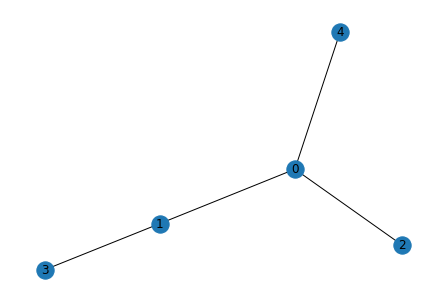

In [9]:
# Prufer to Tree

prufer_to_tree([1,2,1])
print(prufer_to_tree([1,2,1]).toarray())
nx.draw(nx.from_numpy_matrix(prufer_to_tree([1,2,1])), with_labels = True)

## Constrained and Exact Models

### Constrained model

Given numbers $d_1, d_2, ..., d_n$, generate a random Prufer code in which vertex 1 appears at most $d_1$ times, vertex 2 appears at most $d_2$ times, etc.

The resulting tree encoded by this "constrained" model corresponds to a tree drawn uniformly at random from the set of all trees whose degrees are at most $d_1+1, d_2+1,..., d_n+1$.

In the "constrained" model, $d_1+d_2+...+d_n$ must be at least $n-2$

### Exact model

Given numbers $d_1, d_2, ..., d_n$ with $d_1+d_2+...+d_n = n-2$, generate a random Prufer sequence in which vertex 1 appears exactly $d_1$ times, vertex 2 appears exactly $d_2$ times, etc.

The resulting tree encoded by this Prufer sequence corresponds to a tree drawn uniformly from all trees with degrees $d_1, d_2, ..., d_n$ where $d_1, d_2, ..., d_n$ are non-negative integers. 

In the "exact" model, $d_1+d_2+...+d_n$ must be exactly $n-2$

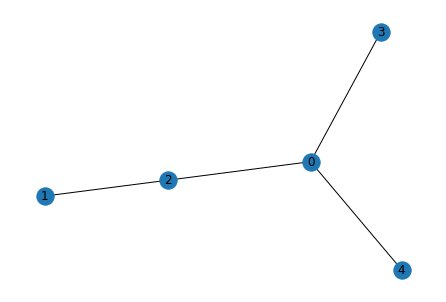

In [10]:
nx.draw(nx.from_numpy_matrix(prufer_to_tree([3,1,1])), with_labels = True)

In [132]:
# Constrained model
def constrained_model_prufer(num_node, lim):
    n = num_node
    condition = tuple(0 for _ in range(num_node))
    while sum(condition) < n-2: # keep finding set of ds until satisfying condition
        condition = tuple(random.randint(0,lim) for i in range(num_node))
    vertex_list = list(range(n))

    prufer_seq = []
    vertex_count = {v:0 for v in vertex_list}
    
    if sum(condition) >= n-2: # condition for constrained model
        while len(prufer_seq) < n-2: # check if the seq reaches the maximum length 
            # 1. random the vertex to be added in the sequence
            v = random.choice(vertex_list)
            # 2. obtain the maximum number of times that the vertex can appear
            d = condition[v]
            #print("The random vertex is", v, "with d =", d)
            # 3. if the vertex hasn't reached the maximum number, add to sequence
            if vertex_count[v] < d:
                prufer_seq.append(v)
                vertex_count[v] += 1 # update the vertex_count
            elif vertex_count[v] == d: # already reached the maximum, rerandom vertex
                #print("This vertex reaches the maximum number of times.")
                continue
            else: # when vertex_count[v] > d (error!)
                raise ConditionError("The number of occurrence should not exceed d.")
    else:
        raise ValueError("The sum of Ds must be at least n-2.")
        
    return prufer_seq, condition

# Exact model
def exact_model_prufer(num_node, lim, condition=0):
    n = num_node
    condition = tuple(0 for _ in range(num_node))
    while sum(condition) != n-2: # keep finding set of ds until satisfying condition
        condition = tuple(random.randint(0,lim) for i in range(num_node))
    vertex_list = list(range(n))
    
    prufer_seq = []
    vertex_count = {v:0 for v in vertex_list}
    
    if sum(condition) == n-2: # condition for constrained model
        while sum(vertex_count.values()) < n-2: # each vertex must appear exactly d times
            while len(prufer_seq) < n-2: # check if the seq reaches the maximum length 
                # 1. random the vertex to be added in the sequence
                v = random.choice(vertex_list)
                # 2. obtain the maximum number of times that the vertex can appear
                d = condition[v]
                #print("The random vertex is", v, "with d =", d)
                # 3. if the vertex hasn't reached the maximum number, KEEP adding to sequence
                if vertex_count[v] < d:
                    prufer_seq.append(v)
                    vertex_count[v] += 1 # update the vertex_count
                elif vertex_count[v] == d: # already reached the maximum, rerandom vertex
                    #print("This vertex reaches the maximum number of times.")
                    continue
                else: # when vertex_count[v] > d (error!)
                    raise ConditionError("The number of occurrence should not exceed d.")
    else:
        raise ValueError("The sum of Ds must be at least n-2.")
    return prufer_seq, condition

In [105]:
constrained_model_prufer(5,10)[0]

[0, 3, 1]

In [118]:
start = time.time()
exact_model_prufer(10,10)
end = time.time()
print("Execution time = ", end-start)

Execution time =  2.2603349685668945


If you ran it another time, you would (probably) get a different tree, but one that also obeyed the same degree constraints. If you kept generating random trees in this way, it should be the case that all trees obeying the given degree constraints appear equally often. That is, the resulting distribution of trees should be uniform over the set of all trees that obey the degree constraint. So, to check this, you could do something similar to the experiment that you ran a few months ago: choose a really small version of the problem where you can enumerate all the possible trees that obey the constraint, generate lots of random trees, and count how often each one shows up. If the code is correct, they should all appear approximately equally often.

### Distribution check

In [150]:
trees = [tuple(constrained_model_prufer(500,15)[0]) for _ in range(1000)]

trees_count = {}
for t in trees:
    trees_count[t] = trees_count.get(t,0) + 1
    
# Calculate probability
prob_list = []
n_total = 0
for i in trees_count:
    n_total += trees_count.get(i)

for i in trees_count:
    prob_list.append(trees_count.get(i)/n_total)

In [151]:
prob_list

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,


In [155]:
trees_exact = [tuple(exact_model_prufer(10,1)[0]) for _ in range(1000)]

trees_count = {}
for t in trees_exact:
    trees_count[t] = trees_count.get(t,0) + 1
    
# Calculate probability
prob_list = []
n_total = 0
for i in trees_count:
    n_total += trees_count.get(i)

for i in trees_count:
    prob_list.append(trees_count.get(i)/n_total)

In [156]:
prob_list

[0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,
 0.001,


{0: 3, 1: 4, 2: 2, 3: 2, 4: 0, 5: 4, 6: 1, 7: 5, 8: 1, 9: 5}


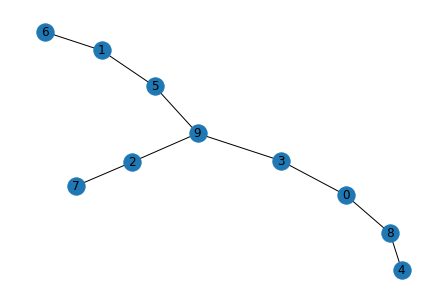

In [136]:
seq = constrained_model_prufer(10,5)[0]
cond = {v:i for (v,i) in enumerate(constrained_model_prufer(10,5)[1])}
nx.draw(nx.from_numpy_matrix(prufer_to_tree(seq)), with_labels=True)
print(cond)

{0: 0, 1: 2, 2: 1, 3: 1, 4: 0, 5: 0, 6: 2, 7: 1, 8: 1, 9: 0}


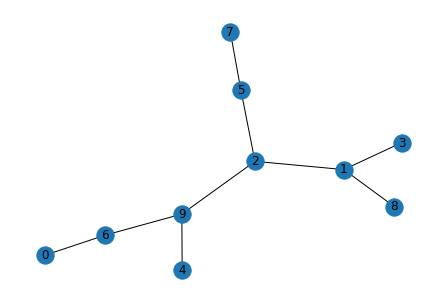

In [157]:
seq = exact_model_prufer(10,2)[0]
cond = {v:i for (v,i) in enumerate(exact_model_prufer(10,2)[1])}
nx.draw(nx.from_numpy_matrix(prufer_to_tree(seq)), with_labels=True)
print(cond)